In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Cell type predictions, full data

### Read in cell type predictions

In [2]:
plt_pred = {}
plt_ct = {}
ct_pred_dict = {}

In [3]:
f_pred_dir = 'cell_type_classification/'
f_list = os.listdir(f_pred_dir)
f_list

['Stanford_2__cell_type_seurat.txt',
 'Broad_1__cell_type_seurat.txt',
 'VIB_2__cell_type_seurat.txt',
 'VIB_Hydrop_2__cell_type_seurat.txt',
 's3atac__cell_type_seurat.txt',
 'Broad_2__cell_type_seurat.txt',
 'CNAG_2__cell_type_seurat.txt',
 'VIB_1__cell_type_seurat.txt',
 'Sanger_1__cell_type_seurat.txt',
 'Broad_mito_2__cell_type_seurat.txt',
 'Broad_mito_1__cell_type_seurat.txt',
 'VIB_Hydrop_1__cell_type_seurat.txt',
 'Sanger_2__cell_type_seurat.txt',
 'CNAG_1__cell_type_seurat.txt',
 'Stanford_1__cell_type_seurat.txt']

In [4]:
ct_pred = {}
for f in f_list:
    k = f.split('__')[0]
    ct_pred[k] = pd.read_csv(os.path.join(f_pred_dir, f), sep='\t')
    
ct_pred_dict['Full'] = ct_pred.copy()

In [5]:
from collections import OrderedDict
alias_dict = OrderedDict({
    "Broad_1": "BioRad ATAC 1",
    "Broad_2": "BioRad ATAC 2",
    "Stanford_1": "10x ATAC A1",
    "Stanford_2": "10x ATAC A2",
    "VIB_1": "10x ATAC B1",
    "VIB_2": "10x ATAC B2",
    "CNAG_1": "10x ATAC C1",
    "CNAG_2": "10x ATAC C2",
    "Broad_mito_1": "10x mtATAC 1",
    "Broad_mito_2": "10x mtATAC 2",
    "Sanger_1": "10x Multiome 1",
    "Sanger_2": "10x Multiome 2",
    "VIB_Hydrop_1": "Hydrop ATAC 1",
    "VIB_Hydrop_2": "Hydrop ATAC 2",
    "s3atac": "s3 ATAC",
    # "merged": "Merged"
})

In [6]:
ct_pred_alias = {}
for x in alias_dict.keys():
    ct_pred_alias[alias_dict[x]] = ct_pred.pop(x)

### Fraction of cells passing thresholds

In [7]:
def calc_frac_cells_passing_threshold(ct_pred, order, step=0.1):
    # calculate fraction of cells passing thresholds
    step = 0.1
    tmp = []
    auc = {}
    threshold_dict = {}
    for k,x in {key: ct_pred[key] for key in order}.items():

        thrs = np.arange(0,1+step,step)
        tmpdf = pd.DataFrame([
            thrs,
            [ sum(x['cell_type_pred_score'] >= thr) for thr in thrs ],
        ]).T
        tmpdf.columns = ['Threshold', 'Score']

        tmpdf['Score'] = tmpdf['Score']/x.shape[0]
        auc[k] = np.trapz(tmpdf['Score'].to_numpy(), x=tmpdf['Threshold'].to_numpy() )
        #tmpdf['Sample'] = k
        tmpdf['Sample'] = f"{k} ({round(auc[k],3)})"
        threshold_dict[k] = round(auc[k],3)
        tmp.append(tmpdf)
        #break
    tp = pd.concat(tmp, ignore_index=True)
    return tp, threshold_dict


def plot_frac_cells_passing_threshold(tp, ax, title="", leg_size=8,
                                      x='Threshold', y='Score',
                                      hue='Sample',
                                      style='Sample',
                                      palette='tab20'
                                     ):
    #dashes=[(''),(2,1)] * int(tp['Sample'].unique().size/2) + ['']
    n = tp['Sample'].unique().size
    if((n % 2) == 0):
        dashes=[(''),(2,1)] * int(n/2)
    else:
        dashes=[(''),(2,1)] * int(n/2) + ['']

    sns.lineplot(x=x, y=y,
                 hue=hue,
                 style=style,
                 dashes=dashes,
                 markers=True,
                 ax=ax,
                 palette=palette,
                 #size=0.8, #alpha=0.8,
                 lw=1,
                 data=tp)
    ax.set_xlabel('Threshold on prediction score')
    ax.set_ylabel('Fraction of cells passing threshold')
    #plt.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=8)
    ax.grid(color='0.9')
    ax.legend(loc=3, fontsize=leg_size)
    ax.set_title(title)

In [8]:
# reorder legends function
import numpy as np
#  Returns tuple of handles, labels for axis ax, after reordering them to conform to the label order `order`, and if unique is True, after removing entries with duplicate labels.
def reorderLegend(ax=None,order=None,unique=False):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # i modified this line 

    return(handles, labels)


def unique_everseen(seq, key=None):
    seen = set()
    seen_add = seen.add
    return [x for x,k in zip(seq,key) if not (k in seen or seen_add(k))]

#source: https://stackoverflow.com/questions/22263807/how-is-order-of-items-in-matplotlib-legend-determined

In [9]:
order = [alias_dict[x] for x in alias_dict.keys()]

In [10]:
tp, threshold_dict = calc_frac_cells_passing_threshold(ct_pred_alias, order, step=0.1)

In [11]:
tp

,Threshold,Score,Sample
0,0.0,1.000000,BioRad ATAC 1 (0.805)
1,0.1,1.000000,BioRad ATAC 1 (0.805)
2,0.2,1.000000,BioRad ATAC 1 (0.805)
3,0.3,0.999490,BioRad ATAC 1 (0.805)
4,0.4,0.998215,BioRad ATAC 1 (0.805)
...,...,...,...
160,0.6,0.747126,s3 ATAC (0.735)
161,0.7,0.588506,s3 ATAC (0.735)
162,0.8,0.425287,s3 ATAC (0.735)
163,0.9,0.254844,s3 ATAC (0.735)


In [12]:
threshold_dict

{'BioRad ATAC 1': 0.805,
 'BioRad ATAC 2': 0.793,
 '10x ATAC A1': 0.842,
 '10x ATAC A2': 0.821,
 '10x ATAC B1': 0.867,
 '10x ATAC B2': 0.807,
 '10x ATAC C1': 0.821,
 '10x ATAC C2': 0.829,
 '10x mtATAC 1': 0.831,
 '10x mtATAC 2': 0.832,
 '10x Multiome 1': 0.824,
 '10x Multiome 2': 0.817,
 'Hydrop ATAC 1': 0.641,
 'Hydrop ATAC 2': 0.602,
 's3 ATAC': 0.735}

In [13]:
# NOTE: the samples will be dislpayed in the order of this dict!
color_dict = OrderedDict({
    "BioRad ATAC 1": "#1f77b4",
    "BioRad ATAC 2": "#aec7e8",
    "10x ATAC A1": "#ff7f0e",
    "10x ATAC A2": "#ffbb78",
    "10x ATAC B1": "#2ca02c",
    "10x ATAC B2": "#98df8a",
    "10x ATAC C1": "#d62728",
    "10x ATAC C2": "#ff9896",
    "10x mtATAC 1": "#9467bd",
    "10x mtATAC 2": "#c5b0d5",
    "10x Multiome 1": "#8c564b",
    "10x Multiome 2": "#c49c94",
    "Hydrop ATAC 1": "#e377c2",
    "Hydrop ATAC 2": "#f7b6d2",
    "s3 ATAC": "#7f7f7f",
    # "Merged": "#111111"
})

In [14]:
color_dict_thr = {}
for x in color_dict.keys():
    color_dict_thr[x + ' (' + str(threshold_dict[x]) + ')'] = color_dict[x]

In [15]:
color_dict_thr

{'BioRad ATAC 1 (0.805)': '#1f77b4',
 'BioRad ATAC 2 (0.793)': '#aec7e8',
 '10x ATAC A1 (0.842)': '#ff7f0e',
 '10x ATAC A2 (0.821)': '#ffbb78',
 '10x ATAC B1 (0.867)': '#2ca02c',
 '10x ATAC B2 (0.807)': '#98df8a',
 '10x ATAC C1 (0.821)': '#d62728',
 '10x ATAC C2 (0.829)': '#ff9896',
 '10x mtATAC 1 (0.831)': '#9467bd',
 '10x mtATAC 2 (0.832)': '#c5b0d5',
 '10x Multiome 1 (0.824)': '#8c564b',
 '10x Multiome 2 (0.817)': '#c49c94',
 'Hydrop ATAC 1 (0.641)': '#e377c2',
 'Hydrop ATAC 2 (0.602)': '#f7b6d2',
 's3 ATAC (0.735)': '#7f7f7f'}

In [16]:
order_thr = color_dict_thr.keys()

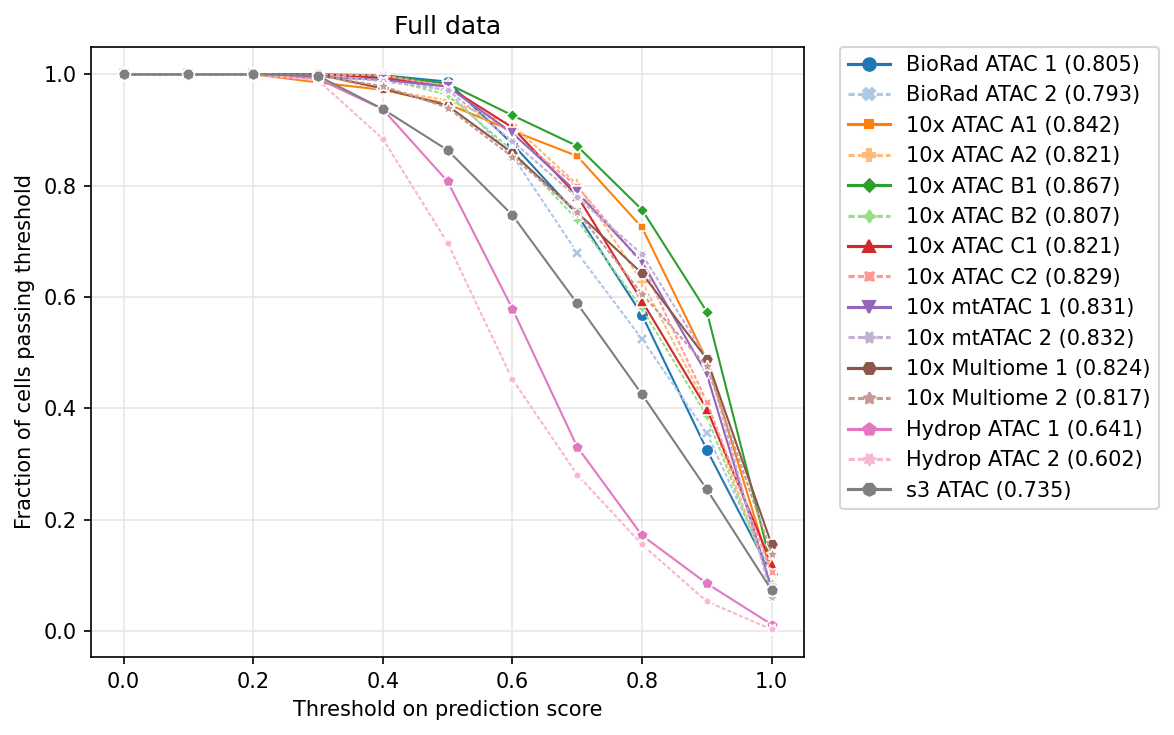

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150 )
plot_frac_cells_passing_threshold(tp, ax, title="Full data", palette=color_dict_thr)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
reorderLegend(ax, order_thr)
tp['Dataset'] = "Full data"
plt_pred['full'] = tp.copy()
plt.savefig(f'plts_pub/full_label_transfer.png', transparent=False, bbox_inches='tight', facecolor='white', dpi=300)
plt.savefig(f'plts_pub/full_label_transfer.svg', transparent=False, bbox_inches='tight', facecolor='white', dpi=300)

### Cell type distributions

In [18]:
ct_pred_alias['BioRad ATAC 1']

,composite_sample_id,barcode,sample_id,cell_type,cell_type_pred_score,cell_type_hiconf_70
0,TAGTGTTGTGGCGCGAGCGTG_GGCAGGCTGGCAACCTTCATC-Br...,TAGTGTTGTGGCGCGAGCGTG_GGCAGGCTGGCAACCTTCATC,Broad_1,CD4+ T cell,0.610633,Unknown
1,CTTGCGAGTGGTAGTCTTGTA_GGTCGTAGCACAGCCATCTTA_TT...,CTTGCGAGTGGTAGTCTTGTA_GGTCGTAGCACAGCCATCTTA_TT...,Broad_1,CD14+ monocyte,0.983182,CD14+ monocyte
2,AATTCCAACCGGCTCTAACTC_GGCGTCCTAAGAGGACCATGC_GC...,AATTCCAACCGGCTCTAACTC_GGCGTCCTAAGAGGACCATGC_GC...,Broad_1,CD4+ T cell,0.878514,CD4+ T cell
3,GCGCACGCGCAATCTAAGAGG_GCAGTGTCGGATCTGGTTAGT_CA...,GCGCACGCGCAATCTAAGAGG_GCAGTGTCGGATCTGGTTAGT_CA...,Broad_1,Cytotoxic T cell,0.549764,Unknown
4,CCGGTTTACCTACCCGGTACG_CTCATTTTTATCATAGCAACG_AA...,CCGGTTTACCTACCCGGTACG_CTCATTTTTATCATAGCAACG_AA...,Broad_1,CD16+ monocyte,0.558353,Unknown
...,...,...,...,...,...,...
3916,CATGTATATTGCCTCACATGA_CGAGTGGACGTTGGGCGCACG_CG...,CATGTATATTGCCTCACATGA_CGAGTGGACGTTGGGCGCACG_CG...,Broad_1,B cell,0.989282,B cell
3917,ATTCGTTTGACCGCAACGGTG_CCAAGCTAATGATTAATTGGT_CG...,ATTCGTTTGACCGCAACGGTG_CCAAGCTAATGATTAATTGGT_CG...,Broad_1,Cytotoxic T cell,0.664163,Unknown
3918,ACAGTACTCTTGTATAAGAGG_GTCGGTTGAGCGTGAAGTGCG-Br...,ACAGTACTCTTGTATAAGAGG_GTCGGTTGAGCGTGAAGTGCG,Broad_1,CD14+ monocyte,0.997578,CD14+ monocyte
3919,AGATAGGCCGAACCTGAGATT_TTAAGCGCGATTACTTGAGGC_TG...,AGATAGGCCGAACCTGAGATT_TTAAGCGCGATTACTTGAGGC_TG...,Broad_1,CD14+ monocyte,1.000000,CD14+ monocyte


In [19]:
def calc_cell_type_dist(ct_pred, order):
    tp = pd.concat([ ct_pred[key] for key in order])
    tp_counts = tp[['sample_id','cell_type']].groupby(['sample_id','cell_type']).size().rename('counts')
    tp = tp_counts.groupby(level=0).apply(lambda x: x / x.sum() ).reset_index(name='fraction')
    return tp   

In [20]:
tp = calc_cell_type_dist(ct_pred_alias, order)

In [21]:
tp['name'] = [alias_dict[x] for x in tp['sample_id']]

In [22]:
def plot_cell_type_dist(tp, ax, title="", leg_size=7, leg_on=True, palette='tab20', order=None):
    g = sns.barplot(data=tp,
        x="cell_type", y="fraction", hue="name", hue_order=order,
        palette=palette, alpha=1,# height=6,
        ax=ax
    )
    ax.set_xlabel('')
    ax.set_ylabel('Fraction of cells')
    g.set_xticklabels(g.get_xticklabels(), rotation=15, ha='right', fontsize=8)
    #plt.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=8)
    ax.grid(color='0.9', axis='y')
    ax.legend(loc=0, fontsize=leg_size)
    ax.set_title(title, fontsize=8)
    return g

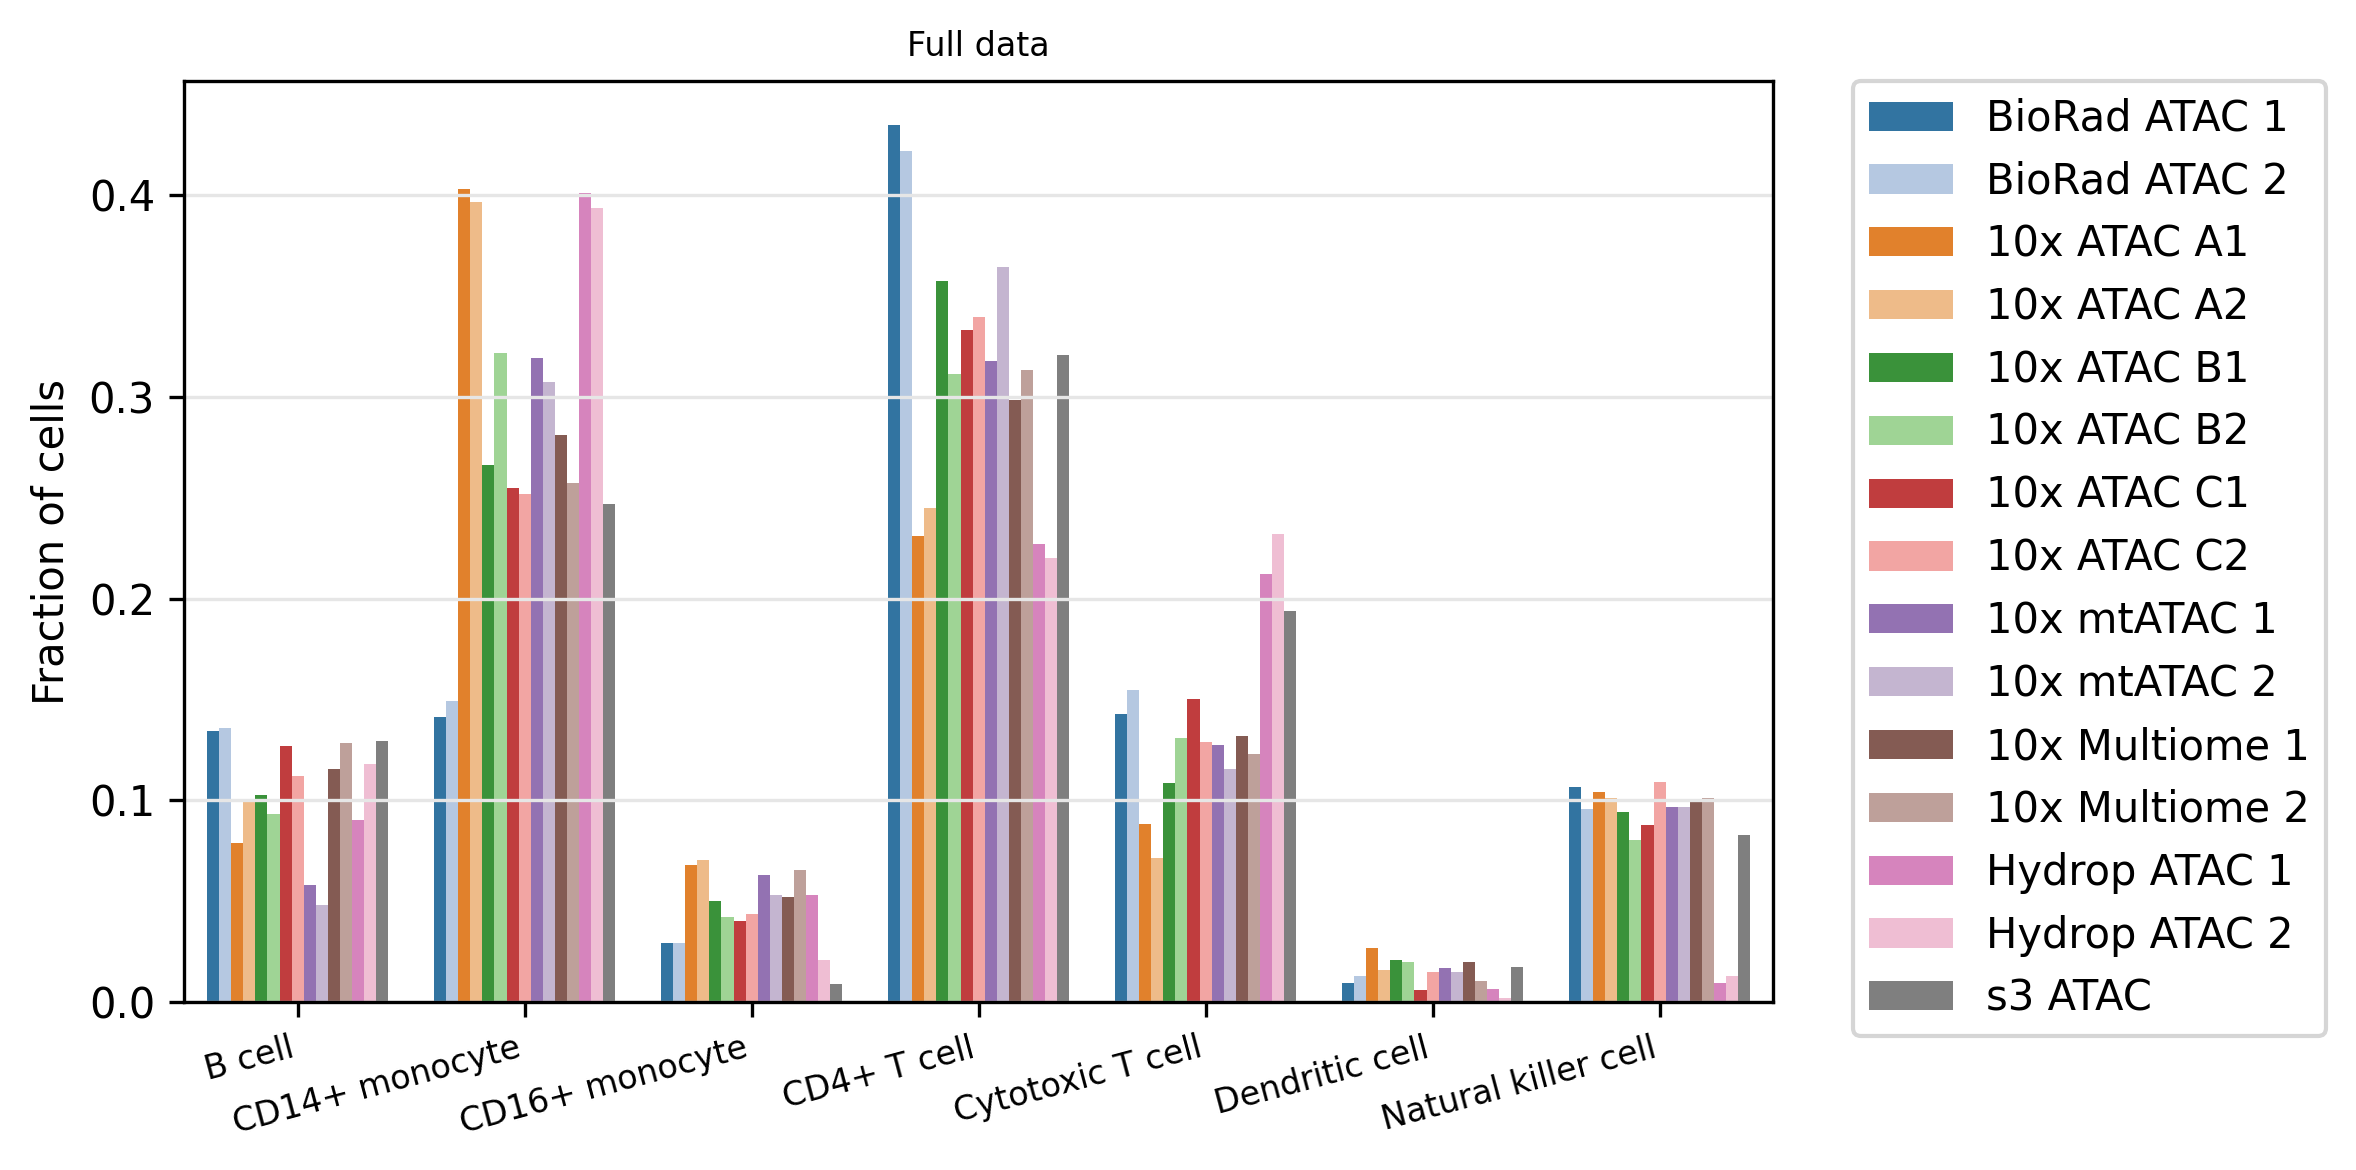

In [23]:
fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=300 )
plot_cell_type_dist(tp, ax, title="Full data", palette=color_dict, order=order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.savefig(f'plts_pub/full_cell_distribution.png', transparent=False, bbox_inches='tight')
plt.savefig(f'plts_pub/full_cell_distribution.svg', transparent=False, bbox_inches='tight')

# Cell type predictions in 10x Multiome

Link RNA + ATAC barcodes for 10x Mulitome and evaluate concordance

In [27]:
import pandas as pd
import numpy as np

### Read in RNA cell type annotations

In [28]:
#f_rna = '/staging/leuven/stg_00002/lcb/cflerin/analysis/pbmc_atac/analysis2/scRNA/cell_type_classification/seurat/10xMO_cell_type_seurat__allcelltypes.txt'
f_rna = '/staging/leuven/stg_00002/lcb/cflerin/analysis/pbmc_atac/analysis2/scRNA/cell_type_classification/seurat/10xMO_cell_type_seurat__filtcelltypes_fullintegratedref.txt'

rna = pd.read_csv(f_rna, sep='\t')
rna

,composite_sample_id,barcode,sample_id,cell_type,cell_type_pred_score,cell_type_hiconf_70
0,AAACAGCCATTGTGCA-1___Sanger_1,AAACAGCCATTGTGCA-1,Sanger_1,CD14+ monocyte,0.630082,Unknown
1,AAACATGCAAGACTCC-1___Sanger_1,AAACATGCAAGACTCC-1,Sanger_1,Natural killer cell,0.691541,Unknown
2,AAACATGCAATATACC-1___Sanger_1,AAACATGCAATATACC-1,Sanger_1,CD14+ monocyte,0.941520,CD14+ monocyte
3,AAACCGAAGCCTGGTA-1___Sanger_1,AAACCGAAGCCTGGTA-1,Sanger_1,CD16+ monocyte,0.939333,CD16+ monocyte
4,AAACCGAAGGAGGTTA-1___Sanger_1,AAACCGAAGGAGGTTA-1,Sanger_1,CD4+ T cell,0.930123,CD4+ T cell
...,...,...,...,...,...,...
7900,TTTGTGTTCTCAATTC-1___Sanger_2,TTTGTGTTCTCAATTC-1,Sanger_2,CD14+ monocyte,0.862248,CD14+ monocyte
7901,TTTGTGTTCTCGACCT-1___Sanger_2,TTTGTGTTCTCGACCT-1,Sanger_2,CD14+ monocyte,0.948432,CD14+ monocyte
7902,TTTGTTGGTAATCGCA-1___Sanger_2,TTTGTTGGTAATCGCA-1,Sanger_2,Natural killer cell,0.339922,Unknown
7903,TTTGTTGGTCATCCTG-1___Sanger_2,TTTGTTGGTCATCCTG-1,Sanger_2,CD14+ monocyte,0.882655,CD14+ monocyte


### Read in ATAC cell type annotations

In [29]:
f_atac = {
'Sanger_1': '/staging/leuven/stg_00002/lcb/cflerin/analysis/pbmc_atac/analysis2/data_freeze_Jun2021/cell_type_classification/predictions__screen/Sanger_1__cell_type_seurat.txt',
'Sanger_2': '/staging/leuven/stg_00002/lcb/cflerin/analysis/pbmc_atac/analysis2/data_freeze_Jun2021/cell_type_classification/predictions__screen/Sanger_2__cell_type_seurat.txt',
}

atac = { k: pd.read_csv(f_atac[k],sep='\t') for k in f_atac }
atac

{'Sanger_1':             composite_sample_id           barcode sample_id         cell_type  \
 0     CCAAGGATCCCTGATA-Sanger_1  CCAAGGATCCCTGATA  Sanger_1    Dendritic cell   
 1     AGTAAACGTATCCGTG-Sanger_1  AGTAAACGTATCCGTG  Sanger_1  Cytotoxic T cell   
 2     TACCGAACATTAACCC-Sanger_1  TACCGAACATTAACCC  Sanger_1    CD14+ monocyte   
 3     ACTAGCCTCCAGGATG-Sanger_1  ACTAGCCTCCAGGATG  Sanger_1    CD14+ monocyte   
 4     TAGGGTTAGGTGCGTA-Sanger_1  TAGGGTTAGGTGCGTA  Sanger_1    CD14+ monocyte   
 ...                         ...               ...       ...               ...   
 2828  TAGCTAGCAAGCGAAG-Sanger_1  TAGCTAGCAAGCGAAG  Sanger_1       CD4+ T cell   
 2829  CCCGCAATCTAACCGC-Sanger_1  CCCGCAATCTAACCGC  Sanger_1    CD14+ monocyte   
 2830  GCACAGCAGTGAGGAA-Sanger_1  GCACAGCAGTGAGGAA  Sanger_1    CD14+ monocyte   
 2831  CAAGGTGTCGTTTCTC-Sanger_1  CAAGGTGTCGTTTCTC  Sanger_1    CD14+ monocyte   
 2832  GGATTGAGTCGCATAT-Sanger_1  GGATTGAGTCGCATAT  Sanger_1    CD14+ monocyte   
 
  

### Read in barcode multiplet mappings

In [30]:
f_multiplet = {
    'Sanger_1': '/staging/leuven/stg_00002/lcb/cflerin/analysis/pbmc_atac/analysis2/data_freeze_Jun2021/atac_preprocess/multiplet_tagged/barcode_translate/Sanger_1__barcode_translate.tsv',
    'Sanger_2': '/staging/leuven/stg_00002/lcb/cflerin/analysis/pbmc_atac/analysis2/data_freeze_Jun2021/atac_preprocess/multiplet_tagged/barcode_translate/Sanger_2__barcode_translate.tsv',
}

multiplet = { k: pd.read_csv(f_multiplet[k], sep='\t', header=None, names=['barcode','barcode_mm']) for k in f_multiplet }
multiplet

{'Sanger_1':                  barcode                                         barcode_mm
 0       AACCTGCTCCACCTGG                  AACCTGCTCCACCTGG_GCATTCATCGTTGTCA
 1       GCATTCATCGTTGTCA                  AACCTGCTCCACCTGG_GCATTCATCGTTGTCA
 2       TCCTGTGCATAACCGA                                   TCCTGTGCATAACCGA
 3       CCGAAGTCAGAAACCC  CCGAAGTCAGAAACCC_GCCCAGTGTAAGTGCA_TGTGGCTTCGAC...
 4       GCCCAGTGTAAGTGCA  CCGAAGTCAGAAACCC_GCCCAGTGTAAGTGCA_TGTGGCTTCGAC...
 ...                  ...                                                ...
 736315  CGTACTTCACATAGCA                                   CGTACTTCACATAGCA
 736316  CGTACTTCACATGCAA                                   CGTACTTCACATGCAA
 736317  CGTACTTCAGGTTGTA                                   CGTACTTCAGGTTGTA
 736318  CGTACTTCAACCCTTG                                   CGTACTTCAACCCTTG
 736319  CGTACTTCAGCTCGCT                                   CGTACTTCAGCTCGCT
 
 [736320 rows x 2 columns],
 'Sanger_2':                  barc

### Read in 10x Multiome RNA/ATAC barcode mappings

The Cell Ranger ARC barcode metrics contains the mapping for RNA-ATAC barcodes

In [31]:
f_mo_pbm = {
    'Sanger_1': '/staging/leuven/stg_00002/lcb/lcb_projects/BAP/data_share/data_processed/cellranger_arc_2.0.0/Sanger_1/outs/per_barcode_metrics.csv',
    'Sanger_2': '/staging/leuven/stg_00002/lcb/lcb_projects/BAP/data_share/data_processed/cellranger_arc_2.0.0/Sanger_2/outs/per_barcode_metrics.csv',
}

pbm = { k: pd.read_csv(f_mo_pbm[k],sep=',')[['gex_barcode','atac_barcode']] for k in f_mo_pbm }
for k in pbm.keys():
    pbm[k]['atac_barcode_nogem'] = [ x.split('-')[0] for x in pbm[k]['atac_barcode'] ]

pbm[k]

,gex_barcode,atac_barcode,atac_barcode_nogem
0,AAACAGCCAAACAACA-1,ACAGCGGGTGTGTTAC-1,ACAGCGGGTGTGTTAC
1,AAACAGCCAAACATAG-1,ACAGCGGGTTGTTCTT-1,ACAGCGGGTTGTTCTT
2,AAACAGCCAAACCCTA-1,ACAGCGGGTAACAGGC-1,ACAGCGGGTAACAGGC
3,AAACAGCCAAACCTAT-1,ACAGCGGGTGCGCGAA-1,ACAGCGGGTGCGCGAA
4,AAACAGCCAAACCTTG-1,ACAGCGGGTCCTCCAT-1,ACAGCGGGTCCTCCAT
...,...,...,...
723442,TTTGTTGGTTCTTTAG-1,CGTACTTCATTTGGCT-1,CGTACTTCATTTGGCT
723443,TTTGTTGGTTGTGACA-1,CGTACTTCATGGTGCG-1,CGTACTTCATGGTGCG
723444,TTTGTTGGTTTCGCGC-1,CGTACTTCACCTGGTC-1,CGTACTTCACCTGGTC
723445,TTTGTTGGTTTGACCT-1,CGTACTTCAGTAGGAG-1,CGTACTTCAGTAGGAG


## Create a universal barcode mapping

Include scATAC-seq, scRNA-seq, and multiplet mappings

#### add multiplet mappings to per barcode metrics mappings

In [32]:
bc_map = {}
for k in pbm.keys():
    bc_map[k] = pd.merge(
        left=pbm[k],
        right=multiplet[k],
        left_on='atac_barcode_nogem',
        right_on='barcode',
        how='inner',
        copy=True
    )
    bc_map[k].drop('barcode', axis=1, inplace=True)

bc_map[k]

,gex_barcode,atac_barcode,atac_barcode_nogem,barcode_mm
0,AAACAGCCAAACAACA-1,ACAGCGGGTGTGTTAC-1,ACAGCGGGTGTGTTAC,ACAGCGGGTGTGTTAC
1,AAACAGCCAAACATAG-1,ACAGCGGGTTGTTCTT-1,ACAGCGGGTTGTTCTT,ACAGCGGGTTGTTCTT
2,AAACAGCCAAACCCTA-1,ACAGCGGGTAACAGGC-1,ACAGCGGGTAACAGGC,ACAGCGGGTAACAGGC
3,AAACAGCCAAACCTAT-1,ACAGCGGGTGCGCGAA-1,ACAGCGGGTGCGCGAA,ACAGCGGGTGCGCGAA
4,AAACAGCCAAACCTTG-1,ACAGCGGGTCCTCCAT-1,ACAGCGGGTCCTCCAT,ACAGCGGGTCCTCCAT
...,...,...,...,...
723442,TTTGTTGGTTCTTTAG-1,CGTACTTCATTTGGCT-1,CGTACTTCATTTGGCT,CGTACTTCATTTGGCT
723443,TTTGTTGGTTGTGACA-1,CGTACTTCATGGTGCG-1,CGTACTTCATGGTGCG,CGTACTTCATGGTGCG
723444,TTTGTTGGTTTCGCGC-1,CGTACTTCACCTGGTC-1,CGTACTTCACCTGGTC,CGTACTTCACCTGGTC
723445,TTTGTTGGTTTGACCT-1,CGTACTTCAGTAGGAG-1,CGTACTTCAGTAGGAG,CGTACTTCAGTAGGAG


### Merge barcode map with RNA results

In [33]:
bc_map2 = {}
for k in bc_map.keys():
    bc_map2[k] = pd.merge(
        left=rna[rna['sample_id']==k][['barcode','cell_type','cell_type_pred_score','cell_type_hiconf_70']],
        right=bc_map[k][['gex_barcode','barcode_mm']],
        left_on='barcode',
        right_on='gex_barcode',
        how='outer',
        )

bc_map2[k]

,barcode,cell_type,cell_type_pred_score,cell_type_hiconf_70,gex_barcode,barcode_mm
0,AAACAGCCAGCTTACA-1,CD14+ monocyte,0.883588,CD14+ monocyte,AAACAGCCAGCTTACA-1,ACAGCGGGTTAGGTTC
1,AAACATGCACATGCTA-1,CD4+ T cell,0.409251,Unknown,AAACATGCACATGCTA-1,CATTTAGGTTTGACTA
2,AAACATGCAGAATGAC-1,CD4+ T cell,0.994907,CD4+ T cell,AAACATGCAGAATGAC-1,CATTTAGGTCTTAGCG
3,AAACCAACAGCGCTTG-1,Cytotoxic T cell,0.676228,Unknown,AAACCAACAGCGCTTG-1,CTTTATCGTGGACAAC
4,AAACCGAAGCAGGTTT-1,CD4+ T cell,0.899097,CD4+ T cell,AAACCGAAGCAGGTTT-1,TGACTATTCGCCTAAC_TCCGAAACATCCCTCT
...,...,...,...,...,...,...
723442,NaN,NaN,NaN,NaN,TTTGTTGGTTCTTTAG-1,CGTACTTCATTTGGCT
723443,NaN,NaN,NaN,NaN,TTTGTTGGTTGTGACA-1,CGTACTTCATGGTGCG
723444,NaN,NaN,NaN,NaN,TTTGTTGGTTTCGCGC-1,CGTACTTCACCTGGTC
723445,NaN,NaN,NaN,NaN,TTTGTTGGTTTGACCT-1,CGTACTTCAGTAGGAG


### Merge with ATAC

In [34]:
ct_pred = {}
for k in bc_map2.keys():
    ct_pred[k] = pd.merge(
        left=bc_map2[k],
        right=atac[k][['barcode','cell_type','cell_type_pred_score','cell_type_hiconf_70']],
        left_on='barcode_mm',
        right_on='barcode',
        how='inner',
        suffixes=('_rna','_atac'),
    )

ct_pred[k]

,barcode_rna,cell_type_rna,cell_type_pred_score_rna,cell_type_hiconf_70_rna,gex_barcode,barcode_mm,barcode_atac,cell_type_atac,cell_type_pred_score_atac,cell_type_hiconf_70_atac
0,AAACAGCCAGCTTACA-1,CD14+ monocyte,0.883588,CD14+ monocyte,AAACAGCCAGCTTACA-1,ACAGCGGGTTAGGTTC,ACAGCGGGTTAGGTTC,CD14+ monocyte,0.939991,CD14+ monocyte
1,AAACATGCACATGCTA-1,CD4+ T cell,0.409251,Unknown,AAACATGCACATGCTA-1,CATTTAGGTTTGACTA,CATTTAGGTTTGACTA,Cytotoxic T cell,0.523502,Unknown
2,AAACATGCAGAATGAC-1,CD4+ T cell,0.994907,CD4+ T cell,AAACATGCAGAATGAC-1,CATTTAGGTCTTAGCG,CATTTAGGTCTTAGCG,CD4+ T cell,0.953334,CD4+ T cell
3,AAACCAACAGCGCTTG-1,Cytotoxic T cell,0.676228,Unknown,AAACCAACAGCGCTTG-1,CTTTATCGTGGACAAC,CTTTATCGTGGACAAC,Natural killer cell,0.616160,Unknown
4,AAACCGAAGCAGGTTT-1,CD4+ T cell,0.899097,CD4+ T cell,AAACCGAAGCAGGTTT-1,TGACTATTCGCCTAAC_TCCGAAACATCCCTCT,TGACTATTCGCCTAAC_TCCGAAACATCCCTCT,CD4+ T cell,0.976577,CD4+ T cell
...,...,...,...,...,...,...,...,...,...,...
3441,NaN,NaN,NaN,NaN,TCATGTTTCCTGGTCT-1,ACTCCTAAGGTTGTAA,ACTCCTAAGGTTGTAA,CD4+ T cell,0.464239,Unknown
3442,NaN,NaN,NaN,NaN,TCTACCTCAATCGCAC-1,GCGATAAGTTACAACC,GCGATAAGTTACAACC,CD14+ monocyte,0.711262,CD14+ monocyte
3443,NaN,NaN,NaN,NaN,TTAAGCCAGTAATCCA-1,GCTCGATTCAGCTAAA,GCTCGATTCAGCTAAA,B cell,1.000000,B cell
3444,NaN,NaN,NaN,NaN,TTACCTGTCATTGTTC-1,TTCAGTTAGGAGGTAA,TTCAGTTAGGAGGTAA,CD16+ monocyte,0.281974,Unknown


In [35]:
for k in ct_pred.keys():
    tmp = ct_pred[k].dropna()
    print(f"{k}: Overall concordance: {sum(tmp['cell_type_rna']==tmp['cell_type_atac']) / tmp.shape[0]}")

Sanger_1: Overall concordance: 0.8643767705382436
Sanger_2: Overall concordance: 0.8614756488772237


## Plot

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
ord = ['Sanger_1', 'Sanger_2']

# calculate fraction of cells passing thresholds
step = 0.05
thrs = np.arange(0,1+step,step)
tmp = []
auc = {}
auc_within_passing_cells = {}
for k,x in {key: ct_pred[key] for key in ord}.items():
    if(k==5):
        break
    tmpdf = pd.DataFrame([
        thrs,
        [ sum(
            (x.dropna()['cell_type_pred_score_atac'] >= thr) &
            (x.dropna()['cell_type_rna'] == x.dropna()['cell_type_atac'])
             ) for thr in thrs ],
        [ sum(x.dropna()['cell_type_pred_score_atac'] >= thr) for thr in thrs ]
    ]).T
    tmpdf.columns = ['Threshold', 'count', 'n_cells_passing_thr']
    
    tmpdf['Score'] = tmpdf['count']/x.dropna().shape[0]
    auc[k] = np.trapz(tmpdf['Score'].to_numpy(), x=tmpdf['Threshold'].to_numpy() )
    tmpdf['Sample'] = f"{k} ({round(auc[k],3)})"
    
    tmpdf['Score_within_passing_cells'] = tmpdf['count']/tmpdf['n_cells_passing_thr']
    auc_within_passing_cells[k] = np.trapz(tmpdf['Score_within_passing_cells'].to_numpy(), x=tmpdf['Threshold'].to_numpy() )
    tmpdf['Sample_within_passing_cells'] = f"{k} ({round(auc_within_passing_cells[k],3)})"

    tmp.append(tmpdf)
tp = pd.concat(tmp, ignore_index=True)

### Plot the score among all cells

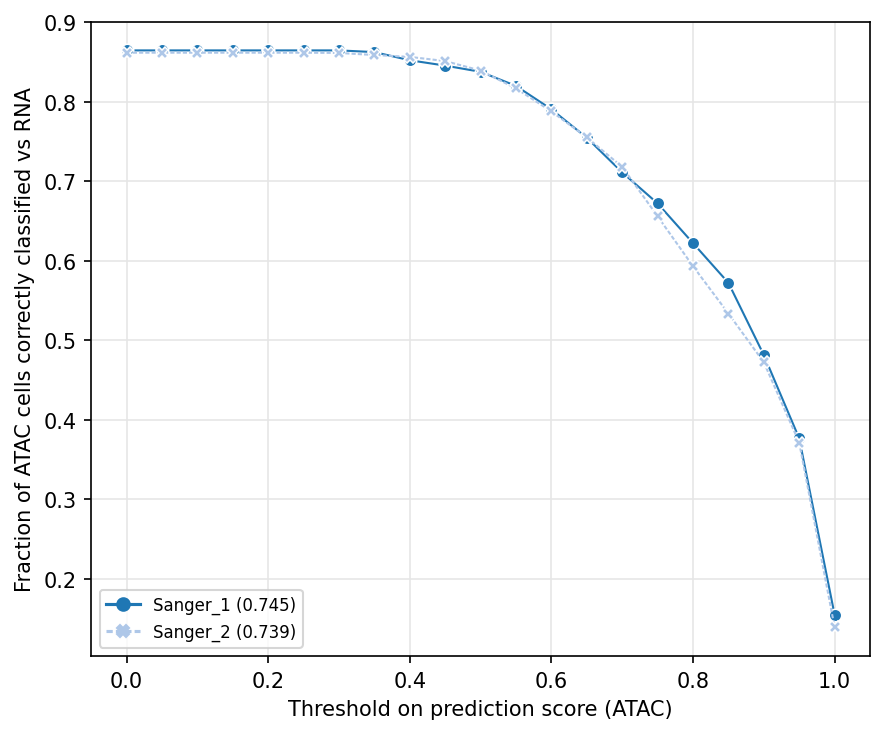

In [38]:
fig, ax = plt.subplots(1,1, figsize=(6,5), dpi=150 )

plot_frac_cells_passing_threshold(tp, ax=ax)
ax.set_xlabel('Threshold on prediction score (ATAC)')
ax.set_ylabel('Fraction of ATAC cells correctly classified vs RNA')

plt.tight_layout()

### Plot the adjusted score

Here, at each threshold, we normalized the number of passing cells (prediction threshold + correctly classified) by dividing by the number of cells passing the prediction score threshold. So at each threshold a different number of cells is considered for the denominator.


For each threshold we have: `(number of cells >= threshold & classified the same as RNA) / (number of cells >= threshold)`

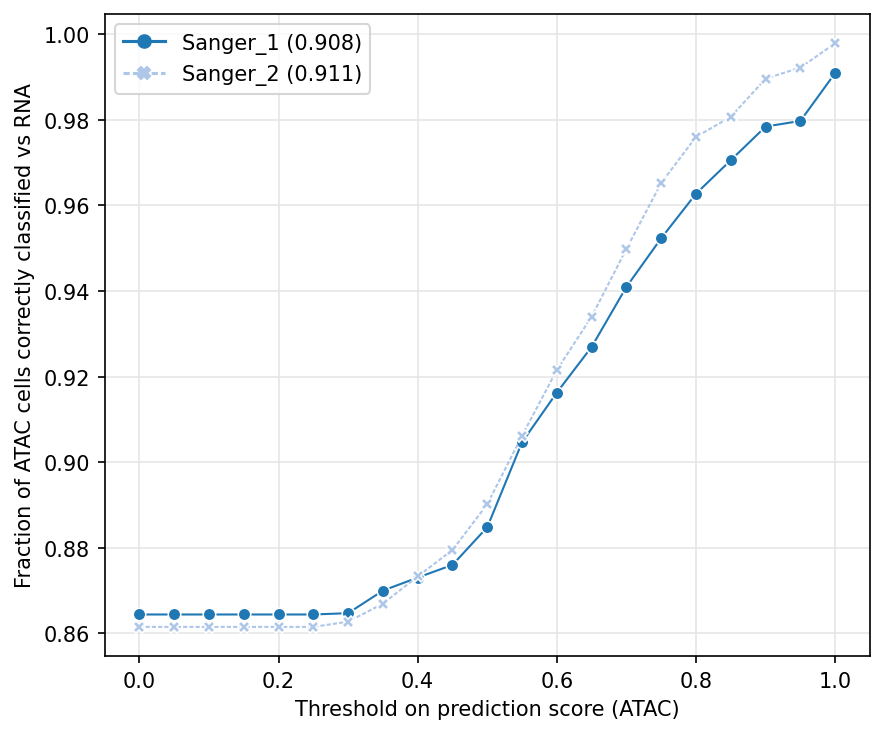

In [39]:
fig, ax = plt.subplots(1,1, figsize=(6,5), dpi=150 )

plot_frac_cells_passing_threshold(tp,
                                  y='Score_within_passing_cells',
                                  hue='Sample_within_passing_cells',
                                  style='Sample_within_passing_cells',                                  
                                  ax=ax)
ax.set_xlabel('Threshold on prediction score (ATAC)')
ax.set_ylabel('Fraction of ATAC cells correctly classified vs RNA')
ax.legend(loc=0)

plt.tight_layout()

### Split by cell type

Score each cell type separately

In [40]:
# calculate fraction of cells passing thresholds for each cell type

ctu = ct_pred['Sanger_1']['cell_type_rna'].dropna().unique().tolist()

step = 0.05
thrs = np.arange(0,1+step,step)
tmp = []
auc = {}
for k,x in {key: ct_pred[key] for key in ord}.items():
    #break
    all_cts = x['cell_type_rna'].dropna().unique().tolist()
    for ct in all_cts:
        x_ct = x[x['cell_type_rna']==ct]
        
        tmpdf = pd.DataFrame([
            thrs,
            [ sum(
                (x_ct.dropna()['cell_type_pred_score_atac'] >= thr) &
                (x_ct.dropna()['cell_type_rna'] == x_ct.dropna()['cell_type_atac'])
                 ) for thr in thrs ],
            [ sum(x_ct.dropna()['cell_type_pred_score_atac'] >= thr) for thr in thrs ]
        ]).T
        tmpdf.columns = ['Threshold', 'count', 'n_cells_passing_thr']
    
        tmpdf['Celltype'] = ct
        # divide by count of this cell type
        tmpdf['Score'] = tmpdf['count']/x_ct.dropna().shape[0]
        auc[k] = np.trapz(tmpdf['Score'].to_numpy(), x=tmpdf['Threshold'].to_numpy() )
        
        #divide by count of this cell type also passing thresholds:
        tmpdf['Score_within_passing_cells'] = tmpdf['count']/tmpdf['n_cells_passing_thr']
        #auc_within_passing_cells[k] = np.trapz(tmpdf['Score_within_passing_cells'].to_numpy(), x=tmpdf['Threshold'].to_numpy() )
        #tmpdf['Sample_within_passing_cells'] = f"{k} ({round(auc_within_passing_cells[k],3)})"        
        
        
        #tmpdf['Sample'] = f"{k} ({round(auc[k],3)})"
        tmpdf['Sample'] = k
        tmp.append(tmpdf)
tp = pd.concat(tmp, ignore_index=True)
tp.fillna(0,inplace=True)

### Plot the score among all cells

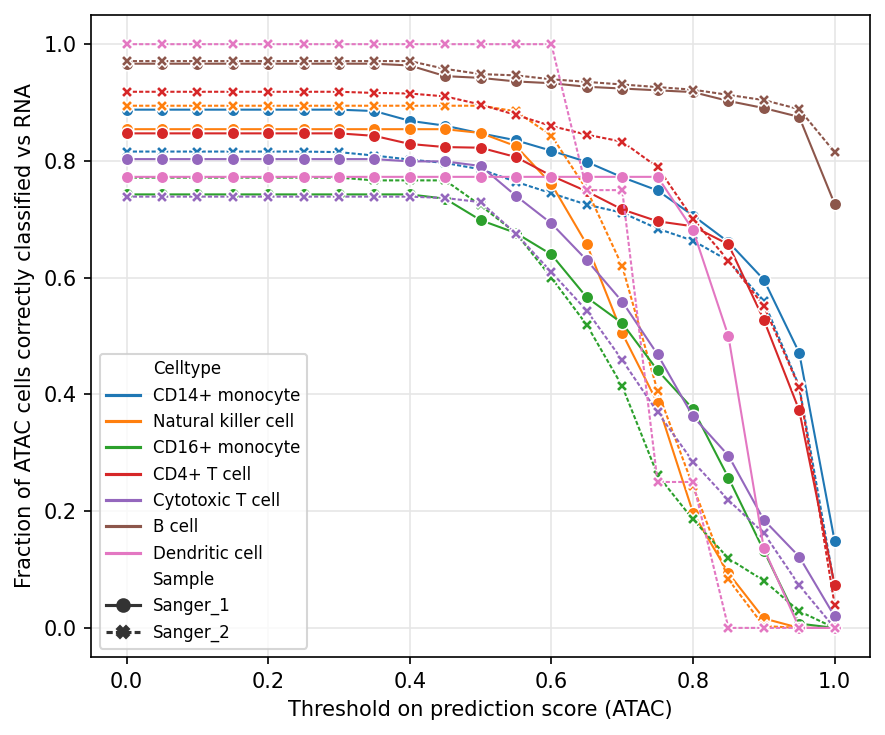

In [41]:
fig, ax = plt.subplots(1,1, figsize=(6,5), dpi=150 )

plot_frac_cells_passing_threshold(tp,
                                  y='Score',
                                  hue='Celltype',
                                  style='Sample',                                  
                                  ax=ax,
                                  palette='tab10'
                                  )
ax.set_xlabel('Threshold on prediction score (ATAC)')
ax.set_ylabel('Fraction of ATAC cells correctly classified vs RNA')
ax.legend(loc=3, fontsize=8)

plt.tight_layout()

### Plot the adjusted score

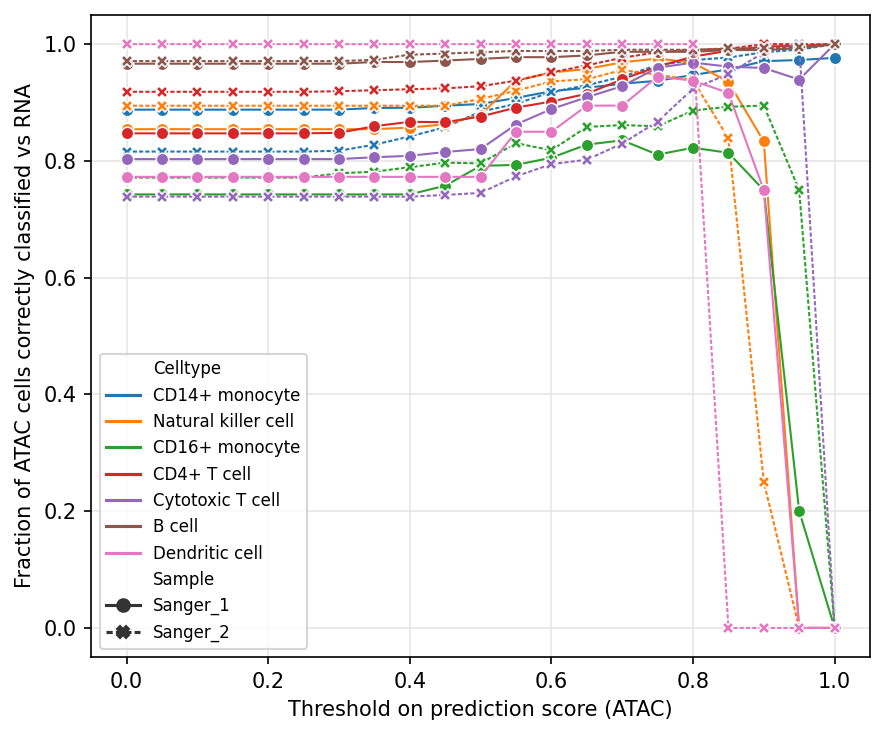

In [42]:
fig, ax = plt.subplots(1,1, figsize=(6,5), dpi=150 )

plot_frac_cells_passing_threshold(tp,
                                  y='Score_within_passing_cells',
                                  hue='Celltype',
                                  style='Sample',                                  
                                  ax=ax,
                                  palette='tab10'
                                  )
ax.set_xlabel('Threshold on prediction score (ATAC)')
ax.set_ylabel('Fraction of ATAC cells correctly classified vs RNA')
ax.legend(loc=3, fontsize=8)

plt.tight_layout()

## Mismatch analysis

In [43]:
all_cts = sorted(list(set(
    ct_pred[k]['cell_type_rna'].dropna().unique().tolist() +
        ct_pred[k]['cell_type_atac'].dropna().unique().tolist()
)))

tp = {}
for k in ct_pred.keys():
    tmp = ct_pred[k][['cell_type_rna','cell_type_atac']].dropna()
    ct_matches = []
    for ct in all_cts:
        # df of rna calls of this type:
        rna_ct = tmp[tmp['cell_type_rna']==ct]
        # count corresponding atac cell types (among rna of this type) for each unique cell type
        ct_matches.append(
            [ sum(rna_ct['cell_type_atac']==atac_ct) for atac_ct in all_cts ]
        )
    tp[k] = (
    pd.DataFrame(ct_matches,
                 index=all_cts,
                 columns=all_cts
                ).rename_axis('cell_type_atac', axis=1).rename_axis('cell_type_rna', axis=0)
    )

In [44]:
tp[k]

cell_type_atac,B cell,CD14+ monocyte,CD16+ monocyte,CD4+ T cell,Cytotoxic T cell,Dendritic cell,Natural killer cell
cell_type_rna,,,,,,,
B cell,436,4,0,5,2,2,0
CD14+ monocyte,0,834,63,89,9,24,3
CD16+ monocyte,0,43,162,4,0,1,0
CD4+ T cell,2,1,0,924,73,5,1
Cytotoxic T cell,1,1,0,44,314,0,65
Dendritic cell,0,0,0,0,0,4,0
Natural killer cell,3,0,0,5,25,0,280


In [45]:
def plot_ct_heatmap(x, ax, title):
    g = sns.heatmap(x,
                mask=x==0,
                annot=True,
                #cmap=sns.color_palette('Reds_r'),
                cmap=sns.color_palette('Blues'),
                linewidths=0.1,
                linecolor='black',
                cbar=False,
                fmt='d',
                annot_kws={"size": 8},
                ax=ax
               )
    g.set_xticklabels(g.get_xticklabels(), rotation=20, ha='right', fontsize=10)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')

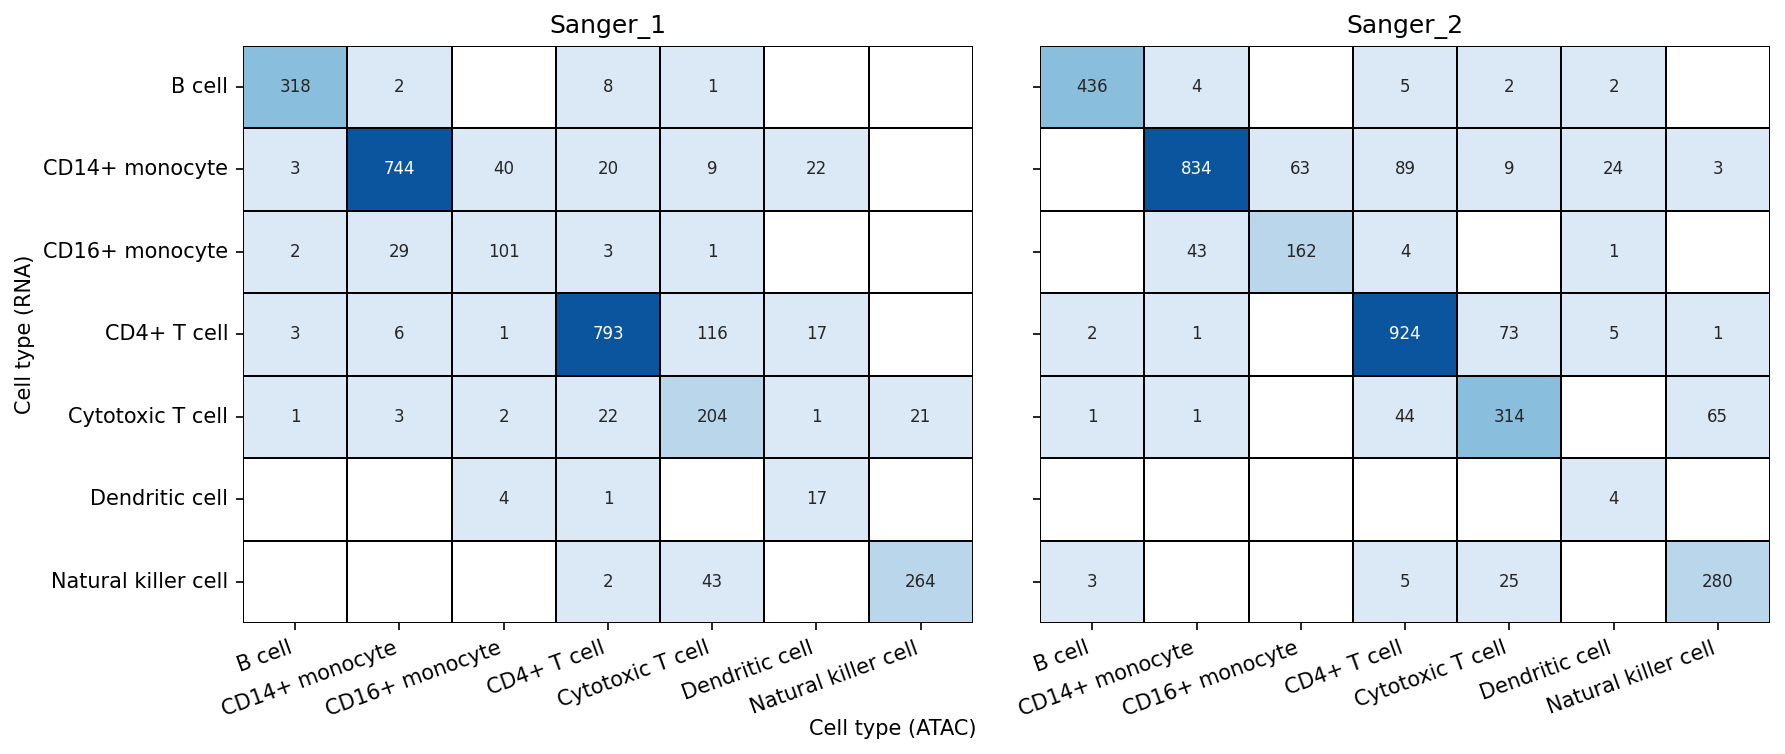

In [46]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5), dpi=150, sharey=True )

plot_ct_heatmap(tp['Sanger_1'], ax=ax1, title='Sanger_1')
plot_ct_heatmap(tp['Sanger_2'], ax=ax2, title='Sanger_2')
ax1.set_ylabel('Cell type (RNA)')
fig.text(0.5, 0.01, 'Cell type (ATAC)', ha='center')
#ax1.set_xlabel('Cell type (ATAC)')
#ax2.set_xlabel('Cell type (ATAC)')

plt.tight_layout()

---